In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F

In [9]:
train = datasets.MNIST('',train=True,download=True, transform = transforms.Compose([transforms.ToTensor()]))

test = datasets.MNIST('',train=False,download=True, transform = transforms.Compose([transforms.ToTensor()]))

trainset = torch.utils.data.DataLoader(train,batch_size=10, shuffle=True)
testset = torch.utils.data.DataLoader(test,batch_size=10, shuffle=False)

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__() #super() ensures that the init fn in parent class is run
        self.fc1 = nn.Linear(28*28,64) #fc1 is first connection 1. 28*28 is the flattened image size. Linear because linear nn
        self.fc2 = nn.Linear(64,64) #input of fc2 is output of fc1, i.e. 64
        self.fc3 = nn.Linear(64,64)
        self.fc4 = nn.Linear(64,10) #output 10 because we have 10 classes in our dict
    
    def forward(self,x):
        x = F.relu(self.fc1(x)) #relu is the rectified linear. it is an activation function that ensures the neuron is 'firing'
        x = F.relu(self.fc2(x))      
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return F.log_softmax(x,dim=1) #dim 1 means we are distributing across the output layer tensors
        
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


The data used from Pytorch is a nice fancy object that is making our life easy, We just need to iterate over it. Next, we want to calculate loss and specify our optimiser:

In [11]:
import torch.optim as optim

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.001) #lr is the learning rate. Keep it small so the optimizer doesnt bounce around

### One_hot array

A one_hot array is an array where only one element is 1 and the rest are 0. The index that is hot is the classification e.g.  
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0,] would be 3.

### Loss functions

Loss functions are a measurement of how far the nn is from the targeted output. A popular one is Mean Squared Error (MSE) but we're trying to use scalar-valued classes.

For one_hot, use MSE.
For scalar classifications like 0,1,2,3,...,9 use cross entropy.

### Optimizer

It is the thing that adjusts the model's adjustable parameters like WEIGHTS, slowly over time to fit data. Adam: __ADA__ptive __M__omentum and it is the standard go-to optimizer. Rectified adam is anothe popular one but it is not available in Pytorch yet. Each pass on the entire dataset is called an **EPOCH**. In general there are 3 to 10 EPOCHS. 

Too few epochs -> model won't learn everything.

Too many epochs -> overfitting occurs

In [12]:
for epoch in range(3): #3 full passes over the data
    for data in trainset: #'data' is a batch of data
        X,y = data #X is a batch of features, y is the batch of targets.
        net.zero_grad() #sets gradients to 0 before loss calc. You will do this likely every step.
        output = net(X.view(-1,784)) #pass in teh reshaped batch (recall they are 28x28 atm)
        loss = F.nll_loss(output,y) #calc and grab the loss value
        loss.backward() #apple this loss backwards thru the network parameters
        optimizer.step() #attempt to optimise weights to account for loss/gradients
    print(loss) #Print loss. hope it declines

tensor(0.0295, grad_fn=<NllLossBackward>)
tensor(0.0686, grad_fn=<NllLossBackward>)
tensor(0.0037, grad_fn=<NllLossBackward>)


It is important to do **net.zero_grad()** for every step otherwise the gradients will add up for each pass.

### So for each epoch and each batch in our datasets what happens?  
1. Grab the features (X) and the labels (y) from the current batch  
2. Zero the gradients (net.zero_grad())  
3. Pass the data through the network  
4. Calculate the loss  
5. Adjust weights in the network with hopes of decereasing loss

As we iterate, we get loss, which is an important metric but we care about accuracy. So how did we do? Iterate over the test set and measure for correctness by comparing output to target values.

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in testset:
        X, y = data
        output = net(X.view(-1,784))
        #print output
        for idx, i in enumerate(output):
            #print(torch.argmax(i), y[idx])
            if torch.argmax(i)==y[idx]:
                correct+=1
            total +=1
            
print('Accuracy:',round(correct/total,3))

Accuracy: 0.966


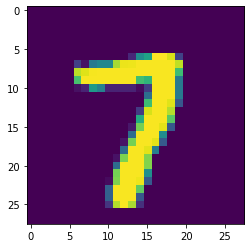

tensor(7)


In [19]:
import matplotlib.pyplot as plt

plt.imshow(X[0].view(28,28))
plt.show()

print(torch.argmax(net(X[0].view(-1,784))[0]))

What `print(torch.argmax(net(X[0].view(-1,784))[0]))` is doing:  

1. Takes in the featureset X[0]
2. Reshape it as a 1x784 tensor for the network.
3. Gets the output (list of network predictions) after passing through the network. This is due to the \__init\__ function.
4. The first prediction is the 0th element in the output.
5. The prediction is the largest value in this tensor.
